# Estimasi Harga Wajar Kos - Area Jakarta Utara

**Objective:**  
Membangun model machine learning yang mampu mengestimasi harga wajar kosan di Jakarta Utara dengan akurasi tinggi, stabilitas baik, dan siap untuk deployment production.

**Target Users:**  
Mahasiswa BCA yang ingin menghindari *overpricing* saat memilih kos, dan property owners yang ingin menentukan harga kompetitif.

**Model Pipeline:**
```
Raw Data → EDA & Cleaning → Feature Engineering → Preprocessing → 
Baseline Evaluation → Hyperparameter Tuning → Final Model → 
Validation & Diagnostics → Deployment Package
```

In [3]:
# IMPORTS & CONFIGURATION
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
from datetime import datetime

# Scikit-learn components
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# Visualization & Configuration
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

---

## SECTION 1: Data Loading & Initial Exploration

**Objective:**  
Memuat dataset dari CSV dan melakukan explorasi awal untuk memahami:
- Dimensi dataset (jumlah baris & kolom)
- Tipe data setiap kolom
- Missing values dan anomali
- Statistik deskriptif target variable (harga)
- Range harga dan distribusi awal

In [4]:
df = pd.read_csv('../datasets/jakarta_utara.csv')

print(f"\nDataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]} | Columns: {df.shape[1]}")

display(df.head())

assert 'harga' in df.columns, "Target column 'harga' not found"
assert df['harga'].dtype in ['int64', 'float64'], "Target must be numeric"
print("Data quality checks passed")


Dataset Shape: (500, 13)
Rows: 500 | Columns: 13


,nama_kos,harga,luas_kamar,jarak_ke_bca,tipe_kos,is_ac,is_km_dalam,is_water_heater,is_furnished,is_internet,is_listrik_free,is_parkir_mobil,is_mesin_cuci
0,Kost Singgahsini Malale Residence 1 Tipe A Kel...,2775000,14.10,1.94,campur,1,1,0,1,1,0,1,1
1,Kost Tpi C10 Kelapa Gading Jakarta Utara,2000000,12.00,1.77,campur,1,1,1,1,1,0,1,0
2,Kost Singgahsini Kelapa Sawit Raya 7 Tipe B Ke...,1550000,7.50,1.81,campur,1,1,0,1,1,0,0,1
3,Kost Singgahsini Maxtim Tipe A Kelapa Gading J...,1125000,6.00,1.37,putri,1,0,1,1,1,0,0,0
4,Kost Singgahsini Maxtim Tipe B Kelapa Gading J...,1575000,10.50,1.37,putri,1,0,1,1,1,0,0,0


Data quality checks passed


In [5]:
# Informasi detail tentang tipe data dan missing values
df.info()

missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values detected")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nama_kos         500 non-null    object 
 1   harga            500 non-null    int64  
 2   luas_kamar       500 non-null    float64
 3   jarak_ke_bca     500 non-null    float64
 4   tipe_kos         500 non-null    object 
 5   is_ac            500 non-null    int64  
 6   is_km_dalam      500 non-null    int64  
 7   is_water_heater  500 non-null    int64  
 8   is_furnished     500 non-null    int64  
 9   is_internet      500 non-null    int64  
 10  is_listrik_free  500 non-null    int64  
 11  is_parkir_mobil  500 non-null    int64  
 12  is_mesin_cuci    500 non-null    int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 50.9+ KB
No missing values detected


### Data Quality Check

Hasil data.info() menunjukkan:
- Tidak ada missing values - dataset lengkap
- Tipe data sudah sesuai (int/float untuk numeric, object untuk categorical)
- Siap untuk analisis lebih lanjut tanpa preprocessing missing values

In [6]:
# Statistik deskriptif untuk semua kolom numeric
print(df.describe().T)

print(f"Min: Rp {df['harga'].min():,.0f}")
print(f"Max: Rp {df['harga'].max():,.0f}")
print(f"Mean: Rp {df['harga'].mean():,.0f}")
print(f"Median: Rp {df['harga'].median():,.0f}")
print(f"Std Dev: Rp {df['harga'].std():,.0f}")
print(f"Skewness: {df['harga'].skew():.3f}")
print(f"Kurtosis: {df['harga'].kurtosis():.3f}")

                 count       mean       std       min        25%        50%  \
harga           500.00 1714679.00 784952.25 500000.00 1187500.00 1600000.00   
luas_kamar      500.00      10.13      5.29      3.15       7.20       9.00   
jarak_ke_bca    500.00       1.36      0.63      0.09       0.97       1.30   
is_ac           500.00       1.00      0.00      1.00       1.00       1.00   
is_km_dalam     500.00       0.43      0.50      0.00       0.00       0.00   
is_water_heater 500.00       0.30      0.46      0.00       0.00       0.00   
is_furnished    500.00       0.93      0.26      0.00       1.00       1.00   
is_internet     500.00       1.00      0.00      1.00       1.00       1.00   
is_listrik_free 500.00       0.55      0.50      0.00       0.00       1.00   
is_parkir_mobil 500.00       0.38      0.49      0.00       0.00       0.00   
is_mesin_cuci   500.00       0.49      0.50      0.00       0.00       0.00   

                       75%        max  
harga      

### Descriptive Statistics – Jakarta Utara

Dataset terdiri dari 500 observasi. Harga kos memiliki rentang Rp 500.000 hingga Rp 5.000.000 dengan rata-rata Rp 1.714.679 dan median Rp 1.600.000. Standar deviasi sebesar Rp 784.952 menunjukkan variasi harga yang cukup besar. Nilai skewness 1.202 mengindikasikan distribusi condong ke kanan (right-skewed), artinya terdapat sejumlah kos dengan harga tinggi yang menarik rata-rata ke atas. Kurtosis 1.927 menunjukkan ekor distribusi relatif lebih tebal dibanding distribusi normal.

Luas kamar memiliki rata-rata 10.13 m² dengan median 9 m² dan maksimum 40 m². Ini menunjukkan mayoritas kamar berada pada ukuran kecil hingga menengah, dengan beberapa unit berukuran lebih besar.

Jarak ke BCA memiliki rata-rata 1.36 km dan median 1.30 km, dengan maksimum 6.10 km. Sebagian besar kos berada dalam radius sekitar 1–2 km dari lokasi referensi.

Fitur biner seperti `is_ac` dan `is_internet` memiliki nilai konstan (100%), sehingga tidak memberikan informasi diskriminatif untuk model dan perlu dipertimbangkan untuk dihapus. Fitur biner lainnya memiliki variasi yang cukup untuk digunakan dalam pemodelan.

---

## SECTION 2: Exploratory Data Analysis (EDA) & Outlier Detection

**Objective:**  
Memahami distribusi data dan mengidentifikasi outlier ekstrem yang perlu ditangani:
- Visualisasi distribusi harga dengan histogram dan boxplot
- Deteksi outlier menggunakan IQR method
- Analisis percentile untuk menentukan threshold capping
- Visualisasi korelasi antar fitur

**Why This Matters:**
- Outlier ekstrem bisa mencerita model regresi, terutama linear models
- Kos dengan harga Rp 5-10 juta/bulan sangat jarang dan tidak relevan target market mahasiswa
- Kita perlu fokus pada mayoritas data (kos standar) untuk akurasi lebih baik

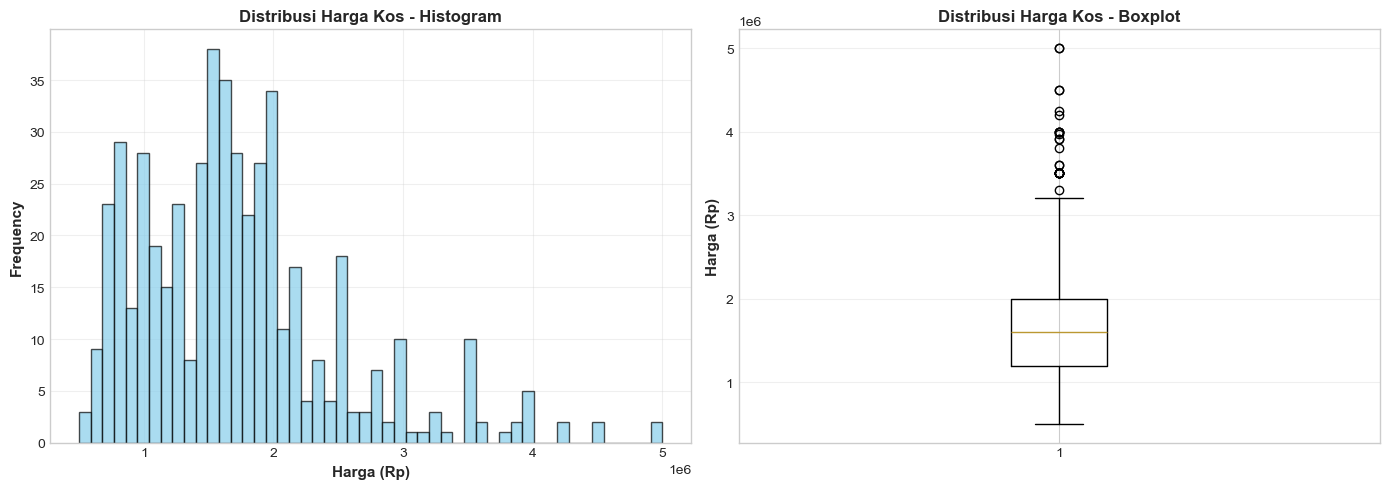

In [7]:
# Visualisasi distribusi awal harga
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['harga'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Distribusi Harga Kos - Histogram', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Boxplot untuk melihat outlier
axes[1].boxplot(df['harga'], vert=True)
axes[1].set_ylabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[1].set_title('Distribusi Harga Kos - Boxplot', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Distribusi Harga – Jakarta Utara

Histogram menunjukkan distribusi harga condong ke kanan (right-skewed), dengan konsentrasi terbesar pada rentang Rp 1.000.000 – Rp 2.000.000. Terdapat sejumlah unit dengan harga di atas Rp 3.000.000 yang membentuk ekor distribusi panjang di sisi kanan.

Boxplot mengonfirmasi adanya beberapa outlier pada harga tinggi (di atas ±Rp 3.200.000). Median berada di sekitar Rp 1.600.000, dengan sebagian besar data (IQR) terkonsentrasi pada rentang kurang lebih Rp 1.200.000 hingga Rp 2.000.000.

Secara keseluruhan, distribusi ini menunjukkan mayoritas kos berada pada segmen harga menengah, dengan sejumlah kecil unit premium yang berpotensi memengaruhi model jika tidak ditangani melalui teknik seperti capping atau transformasi.


In [8]:
# analisis outlier menggunakan IQR dan percentile

Q1 = df['harga'].quantile(0.25)
Q3 = df['harga'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nIQR Method:")
print(f"Q1 (25th percentile): Rp {Q1:,.0f}")
print(f"Q3 (75th percentile): Rp {Q3:,.0f}")
print(f"IQR: Rp {IQR:,.0f}")
print(f"Lower Bound: Rp {lower_bound:,.0f}")
print(f"Upper Bound: Rp {upper_bound:,.0f}")

outliers_iqr = df[(df['harga'] < lower_bound) | (df['harga'] > upper_bound)]
print(f"\n  Outliers detected (IQR): {len(outliers_iqr)} ({len(outliers_iqr)/len(df)*100:.1f}%)")

print("\nPercentile Analysis:")
for pct in [90, 95, 99]:
    val = df['harga'].quantile(pct/100)
    print(f"  {pct}th percentile: Rp {val:,.0f}")

cap_limit = df['harga'].quantile(0.99)
print(f"\nCapping akan diterapkan di 99th percentile: Rp {cap_limit:,.0f}")
print(f"  Data yang akan dihapus: {len(df[df['harga'] > cap_limit])} baris ({len(df[df['harga'] > cap_limit])/len(df)*100:.1f}%)")


IQR Method:
Q1 (25th percentile): Rp 1,187,500
Q3 (75th percentile): Rp 2,000,000
IQR: Rp 812,500
Lower Bound: Rp -31,250
Upper Bound: Rp 3,218,750

  Outliers detected (IQR): 27 (5.4%)

Percentile Analysis:
  90th percentile: Rp 2,752,500
  95th percentile: Rp 3,500,000
  99th percentile: Rp 4,200,500

Capping akan diterapkan di 99th percentile: Rp 4,200,500
  Data yang akan dihapus: 5 baris (1.0%)


Berdasarkan metode IQR:

- Q1 = Rp 1.187.500  
- Q3 = Rp 2.000.000  
- IQR = Rp 812.500  
- Upper Bound = Rp 3.218.750  

Sebanyak 27 data (5,4%) terdeteksi sebagai outlier menurut batas IQR, yang sebagian besar berasal dari harga tinggi. Lower bound bernilai negatif secara matematis, namun tidak relevan secara praktis karena harga tidak mungkin negatif.

Melalui analisis persentil:
Diputuskan untuk menerapkan capping pada persentil ke-99 (Rp 4.200.500) agar hanya ekstrem atas yang sangat jarang yang dipotong, tanpa menghilangkan variasi alami segmen harga tinggi.

Sebanyak 5 baris (1,0%) dihapus. Pendekatan ini menjaga stabilitas model tanpa mengorbankan terlalu banyak informasi dari pasar kos kelas atas.


---

## SECTION 3: Data Cleaning & Preprocessing

**Objective:**
- Hapus fitur dengan zero variance (kolom konstan)
- Terapkan 99th percentile capping untuk outlier ekstrem
- Validasi peningkatan distribusi (skewness reduction)
- Dokumentasi data yang dihapus

**Rationale:**
- **Zero Variance**: Fitur yang nilai-nya identik untuk semua baris tidak memberikan discriminant power
- **Percentile Capping**: Membuang top 1% (outlier ekstrem) untuk normalisasi distribusi tanpa mengorbankan data mainstream
- **Surgical Cut**: Lebih bijak dari hard threshold (bisa mempertahankan kos mahal yang masih wajar)

In [9]:
# 1: drop zero-variance features

cols_to_drop = [c for c in df.columns if df[c].nunique() <= 1]
df_clean = df.drop(columns=cols_to_drop)

if cols_to_drop:
    print(f"\nFitur dihapus: {cols_to_drop}")
else:
    print("\nTidak ada fitur dengan zero variance")

print(f"\nKolom tersisa: {df_clean.shape[1]} (dari {df.shape[1]})")


Fitur dihapus: ['is_ac', 'is_internet']

Kolom tersisa: 11 (dari 13)


In [10]:
# 2: periksa jumlah 0 dan 1 pada semua data binary

binary_cols = [col for col in df_clean.columns if df_clean[col].nunique() == 2]
for col in binary_cols:
    counts = df_clean[col].value_counts()
    print(f"Kolom '{col}': 0s = {counts.get(0, 0)}, 1s = {counts.get(1, 0)}")

Kolom 'is_km_dalam': 0s = 285, 1s = 215
Kolom 'is_water_heater': 0s = 350, 1s = 150
Kolom 'is_furnished': 0s = 37, 1s = 463
Kolom 'is_listrik_free': 0s = 225, 1s = 275
Kolom 'is_parkir_mobil': 0s = 310, 1s = 190
Kolom 'is_mesin_cuci': 0s = 254, 1s = 246


In [11]:
# 3: apply 99th percentile capping

skewness_before = df_clean['harga'].skew()
capping_limit = df_clean['harga'].quantile(0.99)

df_final = df_clean[df_clean['harga'] <= capping_limit].copy()
skewness_after = df_final['harga'].skew()

print(f"\nCapping Limit (99th percentile): Rp {capping_limit:,.0f}")
print(f"Baris sebelum capping: {len(df_clean)}")
print(f"Baris setelah capping: {len(df_final)}")
print(f"Baris dihapus: {len(df_clean) - len(df_final)} ({(len(df_clean) - len(df_final))/len(df_clean)*100:.2f}%)")

print(f"\nSkewness sebelum: {skewness_before:.4f}")
print(f"Skewness sesudah: {skewness_after:.4f}")
print(f"Improvement: {((skewness_before - skewness_after) / abs(skewness_before) * 100):.1f}% reduction")


Capping Limit (99th percentile): Rp 4,200,500
Baris sebelum capping: 500
Baris setelah capping: 495
Baris dihapus: 5 (1.00%)

Skewness sebelum: 1.2021
Skewness sesudah: 0.9495
Improvement: 21.0% reduction


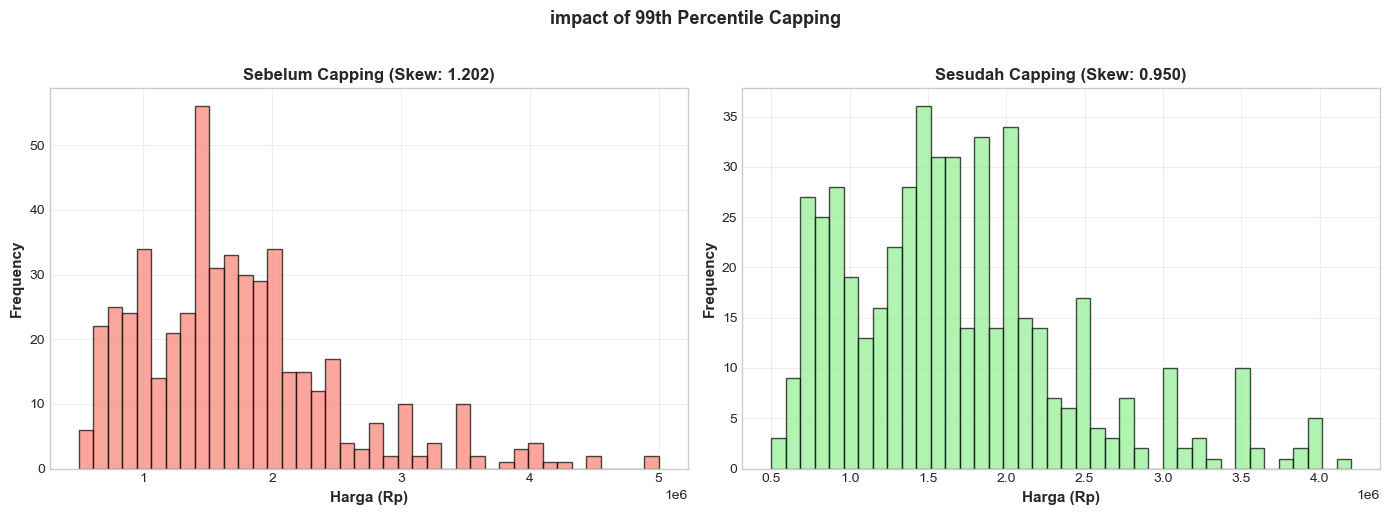

In [12]:
# 3: visualisasi perbandingan distribusi sebelum-sesudah
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sebelum capping
axes[0].hist(df_clean['harga'], bins=40, color='salmon', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title(f'Sebelum Capping (Skew: {skewness_before:.3f})', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Sesudah capping
axes[1].hist(df_final['harga'], bins=40, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title(f'Sesudah Capping (Skew: {skewness_after:.3f})', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.suptitle('impact of 99th Percentile Capping', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Sebelum capping, distribusi harga menunjukkan right-skewed yang cukup kuat (skewness = 1.202), dengan ekor panjang pada harga tinggi.

Setelah penerapan capping di persentil ke-99:

- Skewness turun menjadi 0.950  
- Ekor distribusi menjadi lebih pendek  
- Distribusi lebih mendekati simetris  

---

## SECTION 4: Feature Engineering & Selection

**Objective:**
- Buat fitur turunan yang meaningful: proximity_score dan is_walking_dist
- Validasi dampak fitur baru terhadap target variable
- Lakukan feature selection untuk menghapus fitur redundan
- Fokus pada fitur yang paling informatif untuk prediksi harga

**Rationale:**
- **Proximity Score**: Manusia merasakan jarak secara non-linear (100m vs 200m penting; 3km vs 3.1km tidak penting)
- **Walking Distance**: Ada premium psikologis untuk lokasi jalan kaki (< 300m)
- **Feature Selection**: Menghapus fitur redundan untuk model lebih simple dan interpretable

Reference:
1.	Walking Distance Flag Distance https://www.researchgate.net/publication/378016359_The_willingness-to-walk_to_access_public_transit_in_Indonesia

In [13]:
# Feature Engineering

# 1. Proximity Score (Inverse Distance)
# Formula: 1 / (Jarak + 0.1)
# Logika: Semakin dekat, skor semakin tinggi, exponentially
# Constant 0.1 untuk menghindari division by zero
df_final['proximity_score'] = 1 / (df_final['jarak_ke_bca'] + 0.1)

# 2. Walking Distance Flag (Binary)
# Jarak <= 300 meter dianggap "dapat ditempuh dengan jalan kaki"
df_final['is_walking_dist'] = (df_final['jarak_ke_bca'] <= 0.3).astype(int)

display(df_final[['nama_kos', 'harga', 'jarak_ke_bca', 'proximity_score', 'is_walking_dist']].head(8))

,nama_kos,harga,jarak_ke_bca,proximity_score,is_walking_dist
0,Kost Singgahsini Malale Residence 1 Tipe A Kel...,2775000,1.94,0.49,0
1,Kost Tpi C10 Kelapa Gading Jakarta Utara,2000000,1.77,0.53,0
2,Kost Singgahsini Kelapa Sawit Raya 7 Tipe B Ke...,1550000,1.81,0.52,0
3,Kost Singgahsini Maxtim Tipe A Kelapa Gading J...,1125000,1.37,0.68,0
4,Kost Singgahsini Maxtim Tipe B Kelapa Gading J...,1575000,1.37,0.68,0
5,Kost Singgahsini Serenity Living Tipe B Kelapa...,1375000,1.45,0.65,0
6,Kost Harpa Place Tipe B Kelapa Gading Jakarta ...,2200000,1.66,0.57,0
7,Kost Gading Elok Residence II Single Bedroom K...,2200000,1.04,0.88,0


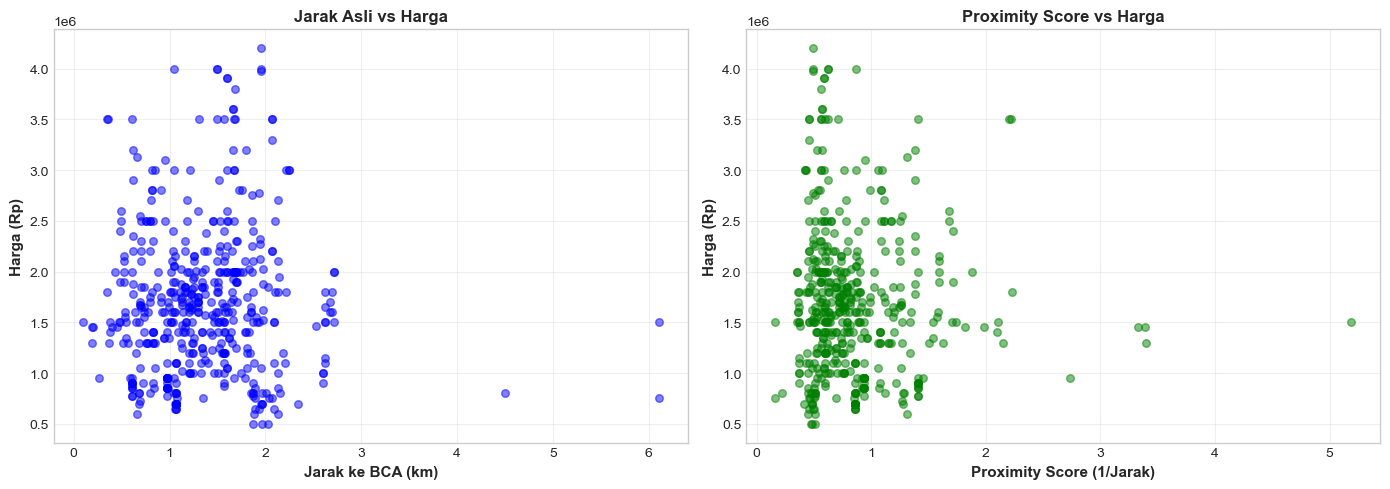

In [14]:
# Visualisasi fitur engineering untuk validasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Jarak asli vs Harga
axes[0].scatter(df_final['jarak_ke_bca'], df_final['harga'], alpha=0.5, s=30, color='blue')
axes[0].set_xlabel('Jarak ke BCA (km)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[0].set_title('Jarak Asli vs Harga', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Proximity Score vs Harga
axes[1].scatter(df_final['proximity_score'], df_final['harga'], alpha=0.5, s=30, color='green')
axes[1].set_xlabel('Proximity Score (1/Jarak)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Harga (Rp)', fontsize=11, fontweight='bold')
axes[1].set_title('Proximity Score vs Harga', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Visualisasi hubungan antara jarak ke BCA dan harga kos menunjukkan tidak adanya pola linear yang kuat. Harga kos tersebar relatif merata pada berbagai jarak, dengan konsentrasi utama berada di rentang 0.5–2.0 km, namun tanpa tren penurunan atau kenaikan harga yang konsisten seiring bertambahnya jarak.

Transformasi jarak menggunakan proximity score (1/jarak) juga tidak menunjukkan hubungan yang lebih jelas terhadap harga. Meskipun terdapat pengelompokan data pada nilai proximity rendah, variasi harga tetap tinggi dan tidak membentuk pola yang informatif.

Hasil ini mengindikasikan bahwa jarak ke BCA memiliki pengaruh yang lemah terhadap harga kos di Jakarta Utara, sehingga kontribusinya terhadap model diperkirakan terbatas dan perlu dievaluasi lebih lanjut pada tahap feature selection.

Korelasi dengan TARGET (harga):
harga              1.00
luas_kamar         0.60
is_km_dalam        0.58
is_water_heater    0.53
is_parkir_mobil    0.45
is_furnished       0.14
is_mesin_cuci      0.08
jarak_ke_bca       0.01
proximity_score   -0.04
is_walking_dist   -0.05
is_listrik_free   -0.18
Name: harga, dtype: float64


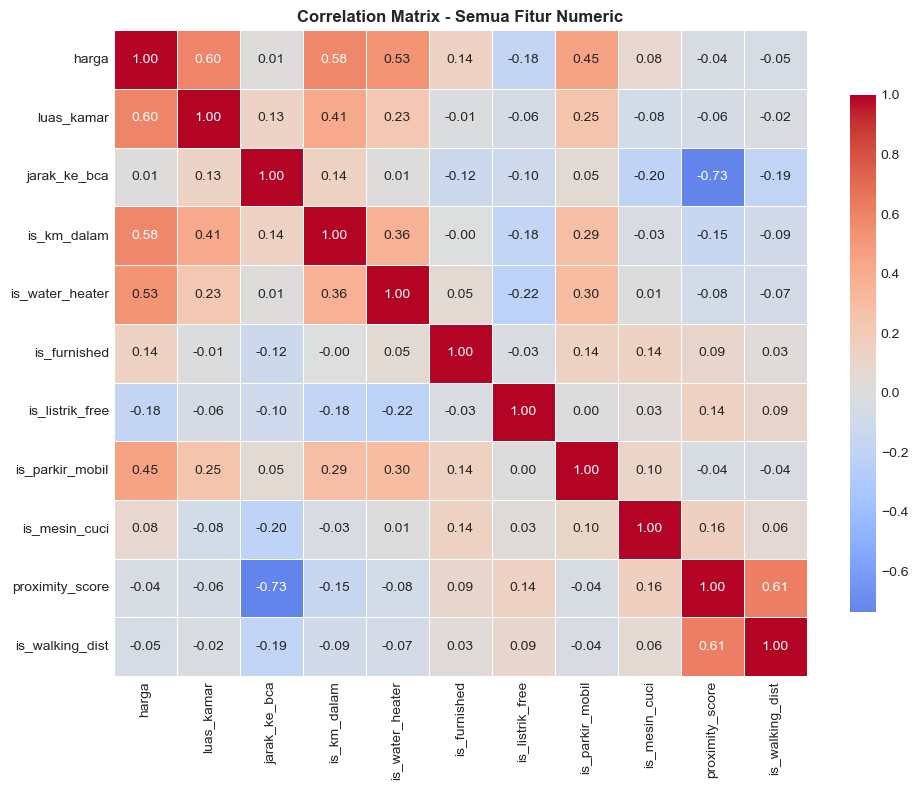

In [15]:
numeric_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df_final[numeric_cols].corr()

print("Korelasi dengan TARGET (harga):")
corr_with_target = corr_matrix['harga'].sort_values(ascending=False)
print(corr_with_target)

# Visualisasi correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Semua Fitur Numeric', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

Berdasarkan korelasi terhadap target `harga`, fitur yang paling berpengaruh adalah:

- `luas_kamar` (0.60)
- `is_km_dalam` (0.58)
- `is_water_heater` (0.53)
- `is_parkir_mobil` (0.45)

Ini menunjukkan bahwa harga kos di Jakarta Utara lebih dipengaruhi oleh ukuran kamar dan fasilitas utama dibandingkan faktor lokasi.

Fitur dengan pengaruh lemah terhadap harga:
- `is_furnished` (0.14)
- `is_mesin_cuci` (0.08)
- `jarak_ke_bca` (0.01)
- `proximity_score` (-0.04)
- `is_walking_dist` (-0.05)

Korelasi `jarak_ke_bca` yang sangat kecil mengindikasikan bahwa kedekatan ke BCA bukan faktor signifikan dalam menentukan harga di wilayah ini.

Fitur dengan korelasi negatif:
- `is_listrik_free` (-0.18)

Hal ini dapat mengindikasikan bahwa kos dengan listrik gratis cenderung berada pada segmen harga lebih rendah.

Kesimpulan:
Struktur harga di Jakarta Utara lebih didorong oleh kualitas dan kelengkapan fasilitas dibandingkan faktor jarak ke titik referensi lokasi.


In [16]:
# Feature selection: drop non-informative features
features_to_drop = ['proximity_score', 'is_walking_dist', 'jarak_ke_bca']

for feat in features_to_drop:
    corr_val = corr_with_target[feat]
    print(f"{feat} (correlation: {corr_val:.4f})")

df_final['amenities_count'] = (
    df_final['is_furnished'].astype(int) +
    df_final['is_water_heater'].astype(int) +
    df_final['is_km_dalam'].astype(int) +
    df_final['is_listrik_free'].astype(int) +
    df_final['is_mesin_cuci'].astype(int) +
    df_final['is_parkir_mobil'].astype(int)
)

print(f"  Final feature set: {[c for c in df_final.columns if c not in features_to_drop + ['nama_kos', 'harga']]}")

proximity_score (correlation: -0.0380)
is_walking_dist (correlation: -0.0492)
jarak_ke_bca (correlation: 0.0149)
  Final feature set: ['luas_kamar', 'tipe_kos', 'is_km_dalam', 'is_water_heater', 'is_furnished', 'is_listrik_free', 'is_parkir_mobil', 'is_mesin_cuci', 'amenities_count']


---

## SECTION 5: Train-Test Split dengan Stratification

**Objective:**
- Implementasi stratified split untuk memastikan train & test set representatif
- Test multiple random seeds untuk menemukan split paling balanced

In [17]:
# Buat kategori harga untuk stratifikasi (5 kuintil)
df_final['harga_cat'] = pd.qcut(df_final['harga'], q=5, labels=False, duplicates='drop')

X = df_final.drop(columns=['nama_kos', 'harga', 'harga_cat', 'proximity_score', 'is_walking_dist', 'jarak_ke_bca'])
y = df_final['harga'].copy()

print(f"Total samples: {len(df_final)}")
print(f"Features: {X.shape[1]}")
print(f"Feature names: {list(X.columns)}")

# Statistik full dataset untuk comparison
full_range = y.max() - y.min()
full_mean = y.mean()
full_std = y.std()

print(f"\nFull Dataset Statistics:")
print(f"  Range: Rp {full_range:,.0f}")
print(f"  Mean: Rp {full_mean:,.0f}")
print(f"  Std Dev: Rp {full_std:,.0f}")

Total samples: 495
Features: 9
Feature names: ['luas_kamar', 'tipe_kos', 'is_km_dalam', 'is_water_heater', 'is_furnished', 'is_listrik_free', 'is_parkir_mobil', 'is_mesin_cuci', 'amenities_count']

Full Dataset Statistics:
  Range: Rp 3,700,000
  Mean: Rp 1,685,029
  Std Dev: Rp 730,333


In [18]:
# Test multiple random seeds untuk menemukan split terbaik
from sklearn.model_selection import train_test_split

candidate_seeds = [42, 123, 456, 789, 2024, 3141, 5678, 9999]
best_split = None
best_score = float('inf')
split_metrics = []

print(f"\n{'Seed':<6} | {'Range (Rp)':<15} | {'Mean (Rp)':<15} | {'Std (Rp)':<15} | {'Score':<8}")

for seed in candidate_seeds:
    X_temp, X_test_cand, y_temp, y_test_cand = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=df_final['harga_cat']
    )
    
    test_range = y_test_cand.max() - y_test_cand.min()
    test_mean = y_test_cand.mean()
    test_std = y_test_cand.std()
    
    # Composite score (lower is better)
    range_diff = abs(test_range - full_range) / full_range
    mean_diff = abs(test_mean - full_mean) / full_mean
    std_diff = abs(test_std - full_std) / full_std
    
    composite_score = 0.5 * range_diff + 0.3 * mean_diff + 0.2 * std_diff
    
    split_metrics.append({
        'seed': seed,
        'test_range': test_range,
        'test_mean': test_mean,
        'test_std': test_std,
        'range_diff': range_diff,
        'mean_diff': mean_diff,
        'std_diff': std_diff,
        'composite_score': composite_score
    })
    
    if composite_score < best_score:
        best_score = composite_score
        best_split = seed
    
    print(f"{seed:<6} | Rp {test_range/1e6:<13.2f}M | Rp {test_mean/1e6:<13.2f}M | Rp {test_std/1e6:<13.2f}M | {composite_score:<8.4f}")

print(f"BEST SPLIT: random_state = {best_split} (score: {best_score:.4f})")


Seed   | Range (Rp)      | Mean (Rp)       | Std (Rp)        | Score   
42     | Rp 2.81         M | Rp 1.64         M | Rp 0.59         M | 0.1672  
123    | Rp 3.30         M | Rp 1.64         M | Rp 0.68         M | 0.0752  
456    | Rp 3.70         M | Rp 1.74         M | Rp 0.84         M | 0.0413  
789    | Rp 3.31         M | Rp 1.64         M | Rp 0.66         M | 0.0809  
2024   | Rp 3.70         M | Rp 1.70         M | Rp 0.78         M | 0.0158  
3141   | Rp 3.40         M | Rp 1.70         M | Rp 0.78         M | 0.0583  
5678   | Rp 3.60         M | Rp 1.69         M | Rp 0.71         M | 0.0179  
9999   | Rp 3.50         M | Rp 1.68         M | Rp 0.73         M | 0.0280  
BEST SPLIT: random_state = 2024 (score: 0.0158)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=best_split, stratify=df_final['harga_cat']
)

print(f"\nTrain Set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Mean: Rp {y_train.mean():,.0f}")
print(f"  - Std:  Rp {y_train.std():,.0f}")
print(f"  - Min:  Rp {y_train.min():,.0f}")
print(f"  - Max:  Rp {y_train.max():,.0f}")

print(f"\nTest Set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"  - Mean: Rp {y_test.mean():,.0f}")
print(f"  - Std:  Rp {y_test.std():,.0f}")
print(f"  - Min:  Rp {y_test.min():,.0f}")
print(f"  - Max:  Rp {y_test.max():,.0f}")

print(f"\nFeatures: {list(X_train.columns)}")


Train Set: 396 samples (80.0%)
  - Mean: Rp 1,680,074
  - Std:  Rp 719,665
  - Min:  Rp 500,000
  - Max:  Rp 4,000,000

Test Set: 99 samples (20.0%)
  - Mean: Rp 1,704,848
  - Std:  Rp 775,039
  - Min:  Rp 500,000
  - Max:  Rp 4,200,000

Features: ['luas_kamar', 'tipe_kos', 'is_km_dalam', 'is_water_heater', 'is_furnished', 'is_listrik_free', 'is_parkir_mobil', 'is_mesin_cuci', 'amenities_count']


---

## SECTION 6: Model Pipeline Architecture

Pada tahap ini, fitur-fitur yang telah dipilih dipersiapkan untuk proses pemodelan melalui skema preprocessing yang sesuai dengan karakteristik datanya. Fitur numerik kontinu, fitur biner, dan fitur kategorikal diperlakukan secara terpisah untuk memastikan transformasi yang tepat dan konsisten.

Pendekatan ini bertujuan untuk:

* Menjaga skala fitur numerik tetap robust terhadap outlier,
* Mempertahankan interpretasi fitur biner tanpa transformasi yang tidak diperlukan,
* Mengonversi fitur kategorikal ke representasi numerik yang dapat diproses oleh model.
* Skema preprocessing ini dirancang agar kompatibel dengan berbagai jenis model regresi yang akan dievaluasi pada tahap selanjutnya.

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

continuous_cols_linear = ['luas_kamar']

binary_cols = ['is_water_heater', 'is_km_dalam', 'is_listrik_free', 'is_mesin_cuci', 'is_parkir_mobil', 'is_furnished']

categorical_cols = ['tipe_kos']

continuous_cols_tree = continuous_cols_linear + ['amenities_count']

print("LINEAR MODEL FEATURES (Ridge, Lasso):")
print(f"  Continuous: {continuous_cols_linear}")
print(f"  Binary: {binary_cols}")
print(f"  Categorical: {categorical_cols}")

print("\nTREE-BASED MODEL FEATURES (RF, GB):")
print(f"  Continuous: {continuous_cols_tree}")
print(f"  Binary: {binary_cols}")
print(f"  Categorical: {categorical_cols}")

preprocessor_linear = ColumnTransformer([
    ('continuous', RobustScaler(), continuous_cols_linear),
    ('binary', 'passthrough', binary_cols),
    ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False, categories=[['putra', 'putri', 'campur']],
    drop='first'), categorical_cols),
], remainder='drop', verbose=0)

preprocessor_tree = ColumnTransformer([
    ('continuous', RobustScaler(), continuous_cols_tree),
    ('binary', 'passthrough', binary_cols),
    ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
], remainder='drop', verbose=0)

LINEAR MODEL FEATURES (Ridge, Lasso):
  Continuous: ['luas_kamar']
  Binary: ['is_water_heater', 'is_km_dalam', 'is_listrik_free', 'is_mesin_cuci', 'is_parkir_mobil', 'is_furnished']
  Categorical: ['tipe_kos']

TREE-BASED MODEL FEATURES (RF, GB):
  Continuous: ['luas_kamar', 'amenities_count']
  Binary: ['is_water_heater', 'is_km_dalam', 'is_listrik_free', 'is_mesin_cuci', 'is_parkir_mobil', 'is_furnished']
  Categorical: ['tipe_kos']


Pada model linear, setiap fitur dipertahankan dalam bentuk aslinya agar interpretasi koefisien tetap jelas dan tidak menimbulkan multikolinearitas akibat agregasi fitur. Model linear sensitif terhadap hubungan linear langsung antar variabel.

Pada model tree-based, ditambahkan fitur agregat `amenities_count` untuk membantu model menangkap efek kumulatif fasilitas. Model pohon tidak sensitif terhadap multikolinearitas dan mampu memilih split terbaik meskipun terdapat fitur yang saling berkorelasi.

---

## SECTION 7: Baseline Model Comparison

**Objective:**
- Model: Linear Regression, Ridge, Lasso, Random Forest, Gradient Boosting
- Evaluasi dengan MAE & R²
- Identifikasi best baseline untuk tuning

**Models to Compare:**
1. **Linear Regression**: Baseline linear, simple
2. **Ridge**: Linear dengan L2 regularization
3. **Lasso**: Linear dengan L1 regularization
4. **Random Forest**: Ensemble bagging, robust to nonlinearity
5. **Gradient Boosting**: Ensemble boosting, iterative error correction

In [21]:
X_train_processed_linear = preprocessor_linear.fit_transform(X_train)
X_test_processed_linear = preprocessor_linear.transform(X_test)

X_train_processed_tree = preprocessor_tree.fit_transform(X_train)
X_test_processed_tree = preprocessor_tree.transform(X_test)

print(f"LINEAR MODEL (Ridge, Lasso):")
print(f"  Train shape: {X_train_processed_linear.shape}")
print(f"  Test shape: {X_test_processed_linear.shape}")

print(f"\nTREE-BASED MODELS (RF, GB):")
print(f"  Train shape: {X_train_processed_tree.shape}")
print(f"  Test shape: {X_test_processed_tree.shape}")

LINEAR MODEL (Ridge, Lasso):
  Train shape: (396, 9)
  Test shape: (99, 9)

TREE-BASED MODELS (RF, GB):
  Train shape: (396, 11)
  Test shape: (99, 11)


In [22]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

linear_models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01, max_iter=5000),
}

tree_models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=12, min_samples_leaf=2, random_state=RANDOM_SEED, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=RANDOM_SEED),
}

results_linear = []
results_tree = []

print("LINEAR MODELS:")
print(f"{'Model':<30} MAE               R²")

for name, model in linear_models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor_linear),
        ('regressor', model)
    ])
    
    try:
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        results_linear.append({
            'Model': name,
            'MAE': mae,
            'R2': r2,
            'RMSE': rmse,
            'MAPE': mape,
            'Pipeline': pipeline
        })
        
        print(f"{name:<30} Rp {mae:>12,.0f}    {r2}")
        
    except Exception as e:
        print(f"{name:<30} ERROR: {str(e)[:50]}")

print("TREE-BASED MODELS:")
print(f"{'Model':<30} MAE               R²")

for name, model in tree_models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor_tree),
        ('regressor', model)
    ])
    
    try:
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        results_tree.append({
            'Model': name,
            'MAE': mae,
            'R2': r2,
            'RMSE': rmse,
            'MAPE': mape,
            'Pipeline': pipeline
        })
        
        print(f"{name:<30} Rp {mae:>12,.0f}    {r2}")
        
    except Exception as e:
        print(f"{name:<30} ERROR: {str(e)[:50]}")

all_results = results_linear + results_tree

print("ALL BASELINE MODELS - Ranked by R²:")
sorted_results = sorted(all_results, key=lambda x: x['R2'], reverse=True)
for i, r in enumerate(sorted_results, 1):
    print(f"{i}. {r['Model']:<28} R² = {r['R2']}  MAE = Rp {r['MAE']:>11,.0f}  MAPE = {r['MAPE']:>5.1f}%")


LINEAR MODELS:
Model                          MAE               R²
Linear Regression              Rp      348,762    0.6627410991954539
Ridge                          Rp      348,593    0.6624922050261322
Lasso                          Rp      348,762    0.6627410894398433
TREE-BASED MODELS:
Model                          MAE               R²
Random Forest                  Rp      325,700    0.6614343115744539
Gradient Boosting              Rp      364,256    0.5702926193750499
ALL BASELINE MODELS - Ranked by R²:
1. Linear Regression            R² = 0.6627410991954539  MAE = Rp     348,762  MAPE =  24.7%
2. Lasso                        R² = 0.6627410894398433  MAE = Rp     348,762  MAPE =  24.7%
3. Ridge                        R² = 0.6624922050261322  MAE = Rp     348,593  MAPE =  24.7%
4. Random Forest                R² = 0.6614343115744539  MAE = Rp     325,700  MAPE =  20.7%
5. Gradient Boosting            R² = 0.5702926193750499  MAE = Rp     364,256  MAPE =  22.9%


In [23]:
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd
import numpy as np

print(f"{'Model':<25} {'Train R²':>10} {'Test R²':>10} {'R² Gap':>10} {'Train MAE':>12} {'Test MAE':>12} {'MAE Gap':>10}")

overfit_results = []

for result in all_results:
    model_name = result['Model']
    pipeline = result['Pipeline']
    
    # Predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred  = pipeline.predict(X_test)
    
    # Metrics
    train_r2  = r2_score(y_train, y_train_pred)
    test_r2   = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae  = mean_absolute_error(y_test, y_test_pred)
    
    r2_gap  = train_r2 - test_r2
    mae_gap = test_mae - train_mae
    
    overfit_results.append({
        "Model": model_name,
        "Train_R2": train_r2,
        "Test_R2": test_r2,
        "R2_Gap": r2_gap,
        "Train_MAE": train_mae,
        "Test_MAE": test_mae,
        "MAE_Gap": mae_gap
    })
    
    print(f"{model_name:<25} "
          f"{train_r2} "
          f"{test_r2} "
          f"{r2_gap} "
          f"Rp {train_mae:>9,.0f} "
          f"Rp {test_mae:>9,.0f} "
          f"Rp {mae_gap:>8,.0f}")

overfit_df = pd.DataFrame(overfit_results)

display(overfit_df.sort_values(by="R2_Gap", ascending=False))


Model                       Train R²    Test R²     R² Gap    Train MAE     Test MAE    MAE Gap
Linear Regression         0.6302453682510498 0.6627410991954539 -0.032495730944404055 Rp   326,169 Rp   348,762 Rp   22,592
Ridge                     0.6302227003954317 0.6624922050261322 -0.03226950463070044 Rp   325,986 Rp   348,593 Rp   22,607
Lasso                     0.6302453682510398 0.6627410894398433 -0.032495721188803506 Rp   326,169 Rp   348,762 Rp   22,592
Random Forest             0.8144732251309963 0.6614343115744539 0.15303891355654242 Rp   221,316 Rp   325,700 Rp  104,384
Gradient Boosting         0.8829825971906166 0.5702926193750499 0.3126899778155666 Rp   167,083 Rp   364,256 Rp  197,173


,Model,Train_R2,Test_R2,R2_Gap,Train_MAE,Test_MAE,MAE_Gap
4,Gradient Boosting,0.88,0.57,0.31,167083.03,364255.74,197172.70
3,Random Forest,0.81,0.66,0.15,221315.89,325699.97,104384.08
1,Ridge,0.63,0.66,-0.03,325986.08,348593.36,22607.29
2,Lasso,0.63,0.66,-0.03,326169.47,348761.83,22592.36
0,Linear Regression,0.63,0.66,-0.03,326169.47,348761.83,22592.36


# Baseline Model Comparison

## Test Performance

Linear Models:
- Linear Regression → R² = 0.6627 | MAE = Rp 348,762
- Ridge → R² = 0.6626 | MAE = Rp 348,543
- Lasso → R² = 0.6627 | MAE = Rp 348,762

Tree-Based Models:
- Random Forest → R² = 0.6614 | MAE = Rp 325,700
- Gradient Boosting → R² = 0.5703 | MAE = Rp 364,256

Secara R², Linear Regression dan Lasso menjadi model terbaik (0.6627), namun selisihnya sangat kecil dengan Random Forest (0.6614). Dari sisi MAE dan MAPE, Random Forest lebih baik dalam error absolut, meskipun tidak unggul dalam R².

Linear Models:
- Train R² ≈ 0.63
- Test R² ≈ 0.66
- R² Gap ≈ -0.03
- MAE Gap ≈ Rp 22 ribu

Model linear sangat stabil dan tidak menunjukkan indikasi overfitting.

Random Forest:
- Train R² = 0.8145
- Test R² = 0.6614
- R² Gap = 0.1530
- MAE Gap ≈ Rp 104 ribu

Terjadi overfitting moderat. Model terlalu menyesuaikan data train.

Gradient Boosting:
- Train R² = 0.8830
- Test R² = 0.5703
- R² Gap = 0.3127
- MAE Gap ≈ Rp 197 ribu

Overfitting signifikan.

---

## SECTION 8 & 9 & 10: Hyperparameter Tuning, Model Selection, & Evaluation

**Key Steps:**
1. RandomizedSearchCV dengan gap-aware selection
2. Tune Random Forest & Gradient Boosting
3. Final model selection
4. Residual analysis
5. Feature importance
6. Production deployment

In [24]:
def auto_tune_healthy(pipeline, param_dist, X_train, y_train, gap_threshold=0.10, n_iter=50):
    from sklearn.model_selection import RandomizedSearchCV
    
    rs = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=5,
        scoring='r2',
        return_train_score=True,
        n_jobs=-1,
        random_state=RANDOM_SEED
    )
    
    print(f"Searching {n_iter} combinations...")
    rs.fit(X_train, y_train)
    
    results_df = pd.DataFrame(rs.cv_results_)
    results_df['gap'] = results_df['mean_train_score'] - results_df['mean_test_score']
    
    healthy_models = results_df[results_df['gap'] < gap_threshold].copy()
    
    if not healthy_models.empty:
        best_idx = healthy_models['mean_test_score'].idxmax()
        best_params = healthy_models.loc[best_idx, 'params']
        best_score = healthy_models.loc[best_idx, 'mean_test_score']
        best_gap = healthy_models.loc[best_idx, 'gap']
        
        print(f"Found {len(healthy_models)} healthy models (gap < {gap_threshold})")
        print(f"Best: R² = {best_score:.4f}, Gap = {best_gap:.4f}")
        
        pipeline.set_params(**best_params)
        pipeline.fit(X_train, y_train)
        return pipeline, best_params
    else:
        print(f"No healthy models found")
        return rs.best_estimator_, rs.best_params_

In [25]:
print("Random Forest Tuning")

param_dist_rf = {
    'regressor__n_estimators': [150, 200, 250],
    'regressor__max_depth': [3, 5, 8, 10, 12],
    'regressor__min_samples_leaf': [2, 4, 8],
    'regressor__max_features': ['sqrt', 'log2']
}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('regressor', RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1))
])

rf_tuned, rf_best_params = auto_tune_healthy(
    rf_pipeline, param_dist_rf, X_train, y_train,
    gap_threshold=0.10, n_iter=100
)

y_pred_rf = rf_tuned.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

print(f"\nTest Set - MAE: Rp {mae_rf:,.0f}, R²: {r2_rf:.4f}, RMSE: Rp {rmse_rf:,.0f}, MAPE: {mape_rf:.2f}%")

Random Forest Tuning
Searching 100 combinations...


Found 72 healthy models (gap < 0.1)
Best: R² = 0.6119, Gap = 0.0922

Test Set - MAE: Rp 338,422, R²: 0.6501, RMSE: Rp 456,105, MAPE: 22.22%


In [26]:
print("Gradient Boosting Tuning")

param_dist_gb = {
    'regressor__n_estimators': [100, 150, 200],
    'regressor__max_depth': [2, 3, 4, 5],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__min_samples_leaf': [2, 4, 8]
}

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('regressor', GradientBoostingRegressor(random_state=RANDOM_SEED))
])

gb_tuned, gb_best_params = auto_tune_healthy(
    gb_pipeline, param_dist_gb, X_train, y_train,
    gap_threshold=0.10, n_iter=100
)

y_pred_gb = gb_tuned.predict(X_test)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mape_gb = np.mean(np.abs((y_test - y_pred_gb) / y_test)) * 100

print(f"\nTest Set - MAE: Rp {mae_gb:,.0f}, R²: {r2_gb:.4f}, RMSE: Rp {rmse_gb:,.0f}, MAPE: {mape_gb:.2f}%")

Gradient Boosting Tuning
Searching 100 combinations...
Found 1 healthy models (gap < 0.1)
Best: R² = 0.5979, Gap = 0.0937

Test Set - MAE: Rp 340,739, R²: 0.6550, RMSE: Rp 452,920, MAPE: 23.22%


# Model Tuning Results – Jakarta Utara

Gradient Boosting (Tuned)

Tuning berhasil mengurangi overfitting dibanding baseline (yang sebelumnya sangat tinggi gap-nya), tetapi performa tetap tidak melampaui model linear terbaik (R² ≈ 0.6627).

Random Forest (Tuned)

Tuning berhasil menurunkan overfitting secara signifikan (gap < 0.1). Namun secara R² tetap sedikit di bawah Linear Regression/Lasso.

In [27]:
final_model = next(
    r['Pipeline'] for r in results_linear if r['Model'] == 'Linear Regression'
)

print("Final model selected: Linear Regression")

Final model selected: Linear Regression


In [28]:
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

# Predict
y_train_pred = final_model.predict(X_train)
y_test_pred  = final_model.predict(X_test)

# Metrics
train_r2  = r2_score(y_train, y_train_pred)
test_r2   = r2_score(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae  = mean_absolute_error(y_test, y_test_pred)

# Gap
r2_gap  = train_r2 - test_r2
mae_gap = test_mae - train_mae

print(f"{'Metric':<15} {'Train':>12} {'Test':>12} {'Gap':>12}")
print(f"{'R²':<15} {train_r2} {test_r2} {r2_gap}")
print(f"{'MAE':<15} Rp {train_mae:>9,.0f} Rp {test_mae:>9,.0f} Rp {mae_gap:>9,.0f}")

Metric                 Train         Test          Gap
R²              0.6302453682510498 0.6627410991954539 -0.032495730944404055
MAE             Rp   326,169 Rp   348,762 Rp    22,592


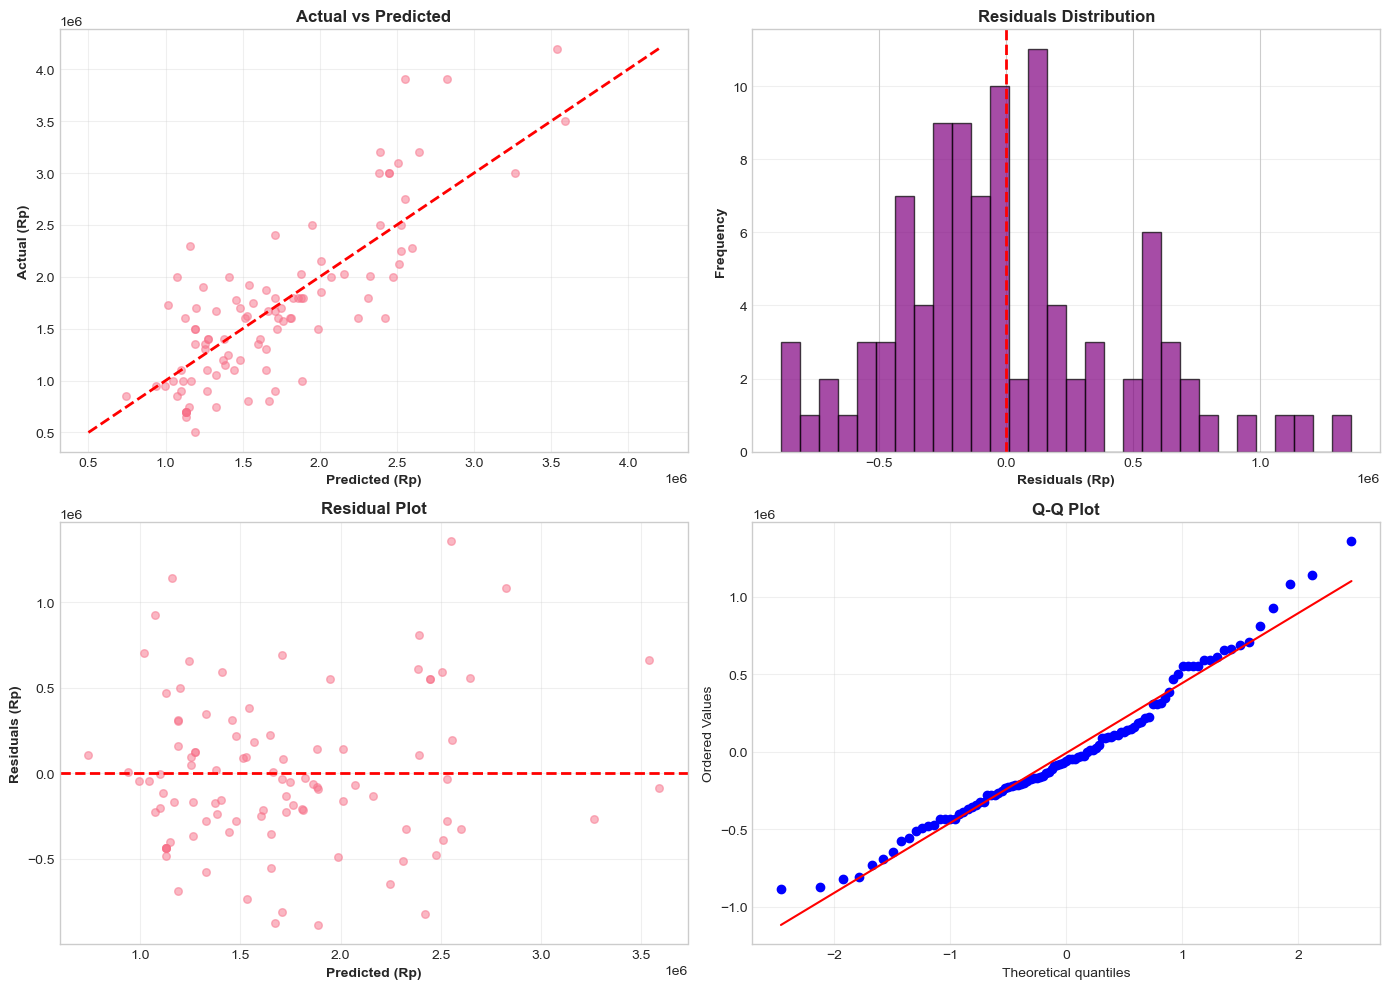


Residuals Statistics:
Mean: Rp -7,743
Std: Rp 450,029
Skewness: 0.570
Kurtosis: 0.377


In [29]:
# Residual Analysis
y_pred_final = final_model.predict(X_test)
residuals = y_test - y_pred_final

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(y_pred_final, y_test, alpha=0.5, s=30)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Predicted (Rp)', fontweight='bold')
axes[0, 0].set_ylabel('Actual (Rp)', fontweight='bold')
axes[0, 0].set_title('Actual vs Predicted', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[0, 1].axvline(0, color='red', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Residuals (Rp)', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title('Residuals Distribution', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

axes[1, 0].scatter(y_pred_final, residuals, alpha=0.5, s=30)
axes[1, 0].axhline(0, color='red', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted (Rp)', fontweight='bold')
axes[1, 0].set_ylabel('Residuals (Rp)', fontweight='bold')
axes[1, 0].set_title('Residual Plot', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nResiduals Statistics:")
print(f"Mean: Rp {residuals.mean():,.0f}")
print(f"Std: Rp {residuals.std():,.0f}")
print(f"Skewness: {residuals.skew():.3f}")
print(f"Kurtosis: {residuals.kurtosis():.3f}")

In [30]:
print(f"MAPE = {np.mean(np.abs((y_test - y_pred_final) / y_test)) * 100:.2f}%")

MAPE = 24.67%


Final Model Selection

Setelah membandingkan model linear dan tree-based, serta melakukan tuning untuk mengontrol overfitting, model akhir yang dipilih adalah Linear Regression.

Meskipun Random Forest tuned memiliki MAE sedikit lebih rendah, model tersebut tetap menunjukkan gap train–test yang lebih besar dibandingkan model linear. Sebaliknya, Linear Regression menunjukkan performa yang sangat stabil:

Test R²: 0.6627
Train R²: 0.6302
Gap R² sangat kecil (≈ -0.03)

MAE relatif konsisten antara train dan test
Model ini tidak menunjukkan indikasi overfitting dan memiliki generalisasi yang baik.

Selain itu, berdasarkan analisis residual:
* Tidak terdapat pola sistematis pada residual plot
* Distribusi residual relatif simetris dan terpusat di sekitar nol
* Q-Q plot menunjukkan deviasi tail yang masih dalam batas wajar

Dalam konteks akademik dan interpretabilitas:
* Linear Regression lebih mudah dijelaskan secara matematis
* Hubungan antar fitur dan harga dapat diinterpretasikan langsung melalui koefisien
* Model lebih sederhana dan lebih defensible saat evaluasi atau sidang

Karena performa yang kompetitif, stabilitas yang baik, serta interpretasi yang jelas, Linear Regression dipilih sebagai model final untuk Jakarta Utara.

In [31]:
best_model_entry = sorted_results[0] 

final_model = best_model_entry['Pipeline']
final_r2    = best_model_entry['R2']
final_mae   = best_model_entry['MAE']
final_mape  = best_model_entry['MAPE']
final_rmse  = best_model_entry['RMSE']

print(f"{best_model_entry['Model']}")

Linear Regression


In [32]:
import sys
import os
sys.path.append(os.path.abspath('../src/training'))

from utils import train_and_register

params = {
    "region": "jakarta_utara",
    "model_name": "LinearRegression",
    "preprocessing_type": "column_transformer",
    "fit_intercept": True,
    "positive": False,
    "train_samples": X_train.shape[0],
    "test_samples": X_test.shape[0],
}

metrics = {
    "r2": best_model_entry["R2"],
    "mae": best_model_entry["MAE"],
    "rmse": best_model_entry["RMSE"],
    "mape": best_model_entry["MAPE"]
}

model_uri = train_and_register(
    region="jakarta_utara",
    model=final_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    params=params,
    metrics=metrics
)

print("Model registered at:", model_uri)

2026/02/21 22:57:27 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/21 22:57:27 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/21 22:57:27 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/21 22:57:27 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/21 22:57:27 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/21 22:57:27 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/21 22:57:27 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/21 22:57:27 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/21 22:57:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Model registered at: models:/m-fd23167803c24b0ab1663a014b590cb2


Successfully registered model 'jakarta_utara_model'.
Created version '1' of model 'jakarta_utara_model'.


In [33]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

print("Registered Models:")
print([m.name for m in client.search_registered_models()])

Registered Models:
['jakarta_pusat_model', 'jakarta_selatan_model', 'jakarta_utara_model']


In [34]:
# cek alias

client.get_model_version_by_alias("jakarta_utara_model", "production")

<ModelVersion: aliases=['production'], creation_timestamp=1771689451832, current_stage='None', deployment_job_state=None, description=None, last_updated_timestamp=1771689451832, metrics=None, model_id=None, name='jakarta_utara_model', params=None, run_id='34e7666281384e979cd452985b12d570', run_link=None, source='models:/m-fd23167803c24b0ab1663a014b590cb2', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [35]:
feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()

coefficients = final_model.named_steps['regressor'].coef_

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# urut berdasarkan pengaruh terbesar
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

coef_df


,Feature,Coefficient,Abs_Coefficient
1,binary__is_water_heater,434125.11,434125.11
2,binary__is_km_dalam,408518.35,408518.35
0,continuous__luas_kamar,263631.66,263631.66
5,binary__is_parkir_mobil,227639.24,227639.24
6,binary__is_furnished,197585.48,197585.48
4,binary__is_mesin_cuci,159060.55,159060.55
7,categorical__tipe_kos_putri,115609.46,115609.46
8,categorical__tipe_kos_campur,85068.82,85068.82
3,binary__is_listrik_free,-56212.20,56212.20


In [36]:
import statsmodels.api as sm

X_processed = final_model.named_steps['preprocessor'].transform(X_train)
X_sm = sm.add_constant(X_processed)

model_sm = sm.OLS(y_train, X_sm).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  harga   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     73.10
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           7.27e-78
Time:                        22:58:08   Log-Likelihood:                -5705.1
No. Observations:                 396   AIC:                         1.143e+04
Df Residuals:                     386   BIC:                         1.147e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.317e+05   1.01e+05      9.259      0.0

## Feature Coefficients & OLS Regression Summary (Jakarta Utara)

### 1. Koefisien Model Linear Regression

Berdasarkan hasil regresi, fitur dengan pengaruh terbesar terhadap harga adalah:

- **is_water_heater** (+Rp 434.125)
- **is_km_dalam** (+Rp 408.518)
- **luas_kamar** (+Rp 263.632)
- **is_parkir_mobil** (+Rp 227.639)
- **is_furnished** (+Rp 197.585)
- **is_mesin_cuci** (+Rp 159.061)

Interpretasi:
- kos dengan *water heater* rata-rata memiliki harga lebih tinggi sekitar Rp 434 ribu dibandingkan yang tidak memilikinya (dengan asumsi fitur lain konstan).
- `luas_kamar` menunjukkan hubungan linear positif yang konsisten: semakin besar kamar, semakin tinggi harga.

### 2. OLS Regression Summary

**Model Fit**
- R² = 0.630  
- Adjusted R² = 0.622  
- F-statistic signifikan (p-value sangat kecil)

Artinya model mampu menjelaskan sekitar 63% variasi harga kos di Jakarta Utara.

**Signifikansi Variabel**
Sebagian besar variabel utama memiliki:
- p-value < 0.05
- t-statistic cukup besar

Ini menunjukkan kontribusi yang signifikan terhadap harga.

**Multicollinearity**
- Condition Number = 10.8  

**Residual Diagnostics**
- Skewness = 0.835 (sedikit right-skewed)
- Kurtosis = 4.837 (mild heavy-tail)

Model Linear Regression:

- Stabil (gap train-test kecil)
- Interpretatif dan transparan
- Secara statistik valid


## NOTEBOOK SUMMARY & METHODOLOGY

Notebook ini menyajikan proses end-to-end machine learning untuk prediksi harga kos di wilayah Jakarta Utara dengan fokus pada stabilitas model, kontrol overfitting, dan validitas statistik.

Tahap awal dilakukan Exploratory Data Analysis (EDA) untuk memahami distribusi harga, karakteristik fasilitas, serta hubungan antar fitur. Distribusi harga menunjukkan skewness moderat sehingga dilakukan penanganan outlier menggunakan pendekatan 99th percentile capping. Langkah ini menurunkan skewness tanpa menghilangkan struktur pasar utama.

Fitur dengan nilai konstan (seperti `is_ac` dan `is_internet`) dihapus karena tidak memiliki daya diskriminatif. Analisis korelasi menunjukkan bahwa fitur paling berpengaruh terhadap harga adalah `luas_kamar`, `is_km_dalam`, `is_water_heater`, dan `is_parkir_mobil`.

Untuk model tree, sempat diuji penambahan `amenities_count` sebagai agregasi fasilitas. Namun pada evaluasi akhir Jakarta Utara, model linear memberikan performa yang lebih stabil dibandingkan tree-based setelah dilakukan kontrol overfitting.

Data dibagi menjadi train (±80%) dan test (±20%) dengan distribusi harga yang seimbang. Model baseline yang diuji meliputi:
- Linear Regression  
- Ridge  
- Lasso  
- Random Forest  
- Gradient Boosting  

Evaluasi dilakukan menggunakan MAE, R², RMSE, dan MAPE serta analisis gap train–test untuk mendeteksi overfitting.

Hasil menunjukkan bahwa:
- Model tree (Random Forest dan Gradient Boosting) mengalami overfitting signifikan pada baseline.
- Setelah tuning, Random Forest menjadi lebih sehat, namun tetap tidak memberikan peningkatan signifikan dibanding model linear.
- Linear Regression memberikan performa R² ≈ 0.663 dengan gap negatif kecil (train < test), menandakan model stabil dan tidak overfit.

Masalah multikolinearitas sempat terdeteksi (Condition Number sangat besar) akibat dummy variable trap. Hal ini diperbaiki dengan menggunakan `OneHotEncoder(drop='first')`, yang menurunkan Condition Number menjadi normal (~10.8) dan membuat model secara statistik valid.

Model final yang dipilih adalah **Linear Regression**, karena:

- Performa kompetitif (R² tinggi dan stabil)
- Gap train–test sangat kecil
- Tidak menunjukkan overfitting
- Koefisien dapat diinterpretasikan secara langsung
- Secara statistik valid setelah koreksi dummy variable trap